# Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


In [1]:
!wget 'https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/DA_data.zip'
!unzip DA_data.zip -x __MACOSX/*

--2025-04-21 23:40:05--  https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/DA_data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/DA_data.zip [following]
--2025-04-21 23:40:06--  https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/DA_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14495014 (14M) [application/zip]
Saving to: ‘DA_data.zip’

DA_data.zip         100%[===================>]  13.82M  27.7MB/s    in 0.5s    

2025-04-21 23:40:07 (27.7 MB/s) - ‘DA_data.zip’ saved [14495014/14495014]


The downloaded dataset should be kept in a data folder in the same directory as this file.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset

import glob
import re
import pandas as pd
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [4]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [5]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [6]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else:
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [7]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

<ipython-input-7-3a505b615f58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags.


You can check the frequency of tags.

To get unique tags:

In [8]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [9]:
tag_dict = {t:i for i,t in enumerate(list(unique_tags))}

In [10]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(tag_dict[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [11]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [12]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [13]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [15]:
MAX_LENGTH = 150

In [16]:
print(X_train[1],y_train[1])

[9, 10, 11, 8] 29


In [17]:
def pad_sequences(sequences, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) for seq in sequences]

train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH)
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH)

In [18]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [19]:
np.array(train_input[11052])


array([ 104,  219,   11, 4590,    9,   32,   11,   24, 4457,   35,  157,
         28,  291,  114,  157,   28,  137,  114,  145,  333,   45, 2128,
       2129,    8,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [20]:
sentence_embeddings[11052]

[104,
 219,
 11,
 4590,
 9,
 32,
 11,
 24,
 4457,
 35,
 157,
 28,
 291,
 114,
 157,
 28,
 137,
 114,
 145,
 333,
 45,
 2128,
 2129,
 8]

In [21]:
train_labels[11052]

np.int64(34)

# Model 1 -

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer

The model architecture is as follows: Embedding Layer (to generate word
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags.


In [22]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags)

In [23]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, max_length):
        super(BiLSTMModel, self).__init__()

        # Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Bidirectional 1
        self.bilstm1 = nn.LSTM(input_size=embed_size,
                              hidden_size=hidden_size,
                              bidirectional=True,
                              batch_first=True)

        # Bidirectional 2
        self.bilstm2 = nn.LSTM(input_size=2*hidden_size,
                              hidden_size=hidden_size,
                              bidirectional=True,
                              batch_first=True)

        # Dense layer
        self.fc = nn.Linear(2*hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length)
        """
        # Embedding layer
        embed = self.embedding(x)  # (batch_size, seq_length, embed_size)

        # First Bidirectional LSTM
        out1, _ = self.bilstm1(embed)  # (batch_size, seq_length, 2*hidden_size)

        # Second Bidirectional LSTM
        out2, (h_n2, c_n2) = self.bilstm2(out1)  # out2: (batch_size, seq_length, 2*hidden_size), h_n2: (2, batch_size, hidden_size)

        # Extract forward and backward hidden states from the second LSTM
        h_n2_fwd = h_n2[0]  # Forward hidden state
        h_n2_bwd = h_n2[1]  # Backward hidden state

        # Concatenate forward and backward hidden states
        h_n2_concat = torch.cat((h_n2_fwd, h_n2_bwd), dim=1)  # (batch_size, 2*hidden_size)

        # Apply dropout and the final dense layer
        h_n2_concat = self.dropout(h_n2_concat)
        probs = self.fc(h_n2_concat)  # (batch_size, hidden_size)

        return probs


# Instantiate the model
model = BiLSTMModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_length=MAX_LENGTH
)
# Print model summary (PyTorch-style)
print(model)

BiLSTMModel(
  (embedding): Embedding(43732, 100)
  (bilstm1): LSTM(100, 43, batch_first=True, bidirectional=True)
  (bilstm2): LSTM(86, 43, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=86, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [24]:
train_input_t = torch.Tensor(train_input)
train_labels_t = torch.Tensor(train_labels)
val_input_t = torch.Tensor(val_input)
val_labels_t = torch.Tensor(val_labels)
test_sentences_X_t = torch.Tensor(test_sentences_X)
y_test_t = torch.Tensor(y_test)

train_dataset = TensorDataset(train_input_t, train_labels_t)
val_dataset = TensorDataset(val_input_t, val_labels_t)
test_dataset = TensorDataset(test_sentences_X_t, y_test_t)

In [25]:
def train(model, train_dataset, val_dataset, epoch_num, lr, batch_size, device, weight=None):
    model.train()
    model = model.to(device)
    if weight:
       weight = torch.Tensor(weight).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epoch_num):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).long(), labels.to(device).long()  # Convert inputs to LongTensor

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}")

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).long(), labels.to(device).long()  # Convert inputs to LongTensor

                # Forward pass
                outputs = model(inputs)

                # Compute validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {correct / total}")


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model, train_dataset, val_dataset, 5, 1e-3, 256, device)

Epoch 1, Train Loss: 1.5403653174039433
Validation Loss: 1.121379188988187, Accuracy: 0.6603378573491192
Epoch 2, Train Loss: 1.1445290614089756
Validation Loss: 1.0105076344735031, Accuracy: 0.6934738665896621
Epoch 3, Train Loss: 1.046557738314599
Validation Loss: 0.9586482244894046, Accuracy: 0.7039055732024256
Epoch 4, Train Loss: 0.9847885689526197
Validation Loss: 0.9244944759465139, Accuracy: 0.7120632399653479
Epoch 5, Train Loss: 0.9337291165069427
Validation Loss: 0.9183231619519925, Accuracy: 0.7143733756858215


In [27]:
def eval(model, test_dataset, batch_size=1, device="cpu"):
    model.eval()
    model.to(device)
    test_loss = 0.0
    test_correct = 0

    criterion = nn.CrossEntropyLoss()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x = test_x.to(torch.int32).to(device)
            test_y = test_y.type(torch.LongTensor).to(device)

            """
            Task 1 3/3

            Begin
            """

            # Forward pass
            outputs = model(test_x)

            # calculate the test loss
            loss = criterion(outputs, test_y)
            test_loss += loss.item() * len(test_y)

            # calculate the test accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == test_y).sum().item()

            """
            End Task 1 3/3
            """


    test_loss /= len(test_dataset)
    test_accuracy = test_correct / len(test_dataset)

    print(f"Overall Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}")

In [28]:
eval(model, test_dataset, 100, device)

Overall Loss: 0.9397, Acc: 0.7098


## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice.

## Minority Classes

In [29]:
"""
Task 2 1/2

Begin
"""
# Generate predictions for the test data
def predict(model, test_dataset, batch_size=100, device="cpu"):
    model.eval()
    model.to(device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    all_preds = []

    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x = test_x.to(torch.int32).to(device)
            outputs = model(test_x)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_preds)

label_pred = predict(model, test_dataset, 100, device)


In [30]:
# Build the confusion matrix off these predictions
matrix = sklearn.metrics.confusion_matrix(y_test, label_pred)


In [31]:
# Find indices for 'br' and 'bf' classes
tag_list = list(tag_dict.keys())
values_list = list(tag_dict.values())

br_idx = tag_list.index('br')
bf_idx = tag_list.index('bf')

# Calculate Accuracies for "br" and "bf"
br_accuracy = matrix[br_idx, br_idx] / np.sum(matrix[br_idx, :]) if np.sum(matrix[br_idx, :]) > 0 else 0
bf_accuracy = matrix[bf_idx, bf_idx] / np.sum(matrix[bf_idx, :]) if np.sum(matrix[bf_idx, :]) > 0 else 0

print(f"Accuracy for 'br' class: {br_accuracy:.4f}")
print(f"Accuracy for 'bf' class: {bf_accuracy:.4f}")

"""
End Task 2 1/2
"""

Accuracy for 'br' class: 0.1791
Accuracy for 'bf' class: 0.0000


'\nEnd Task 2 1/2\n'

## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here.




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare.

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class.

In [32]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


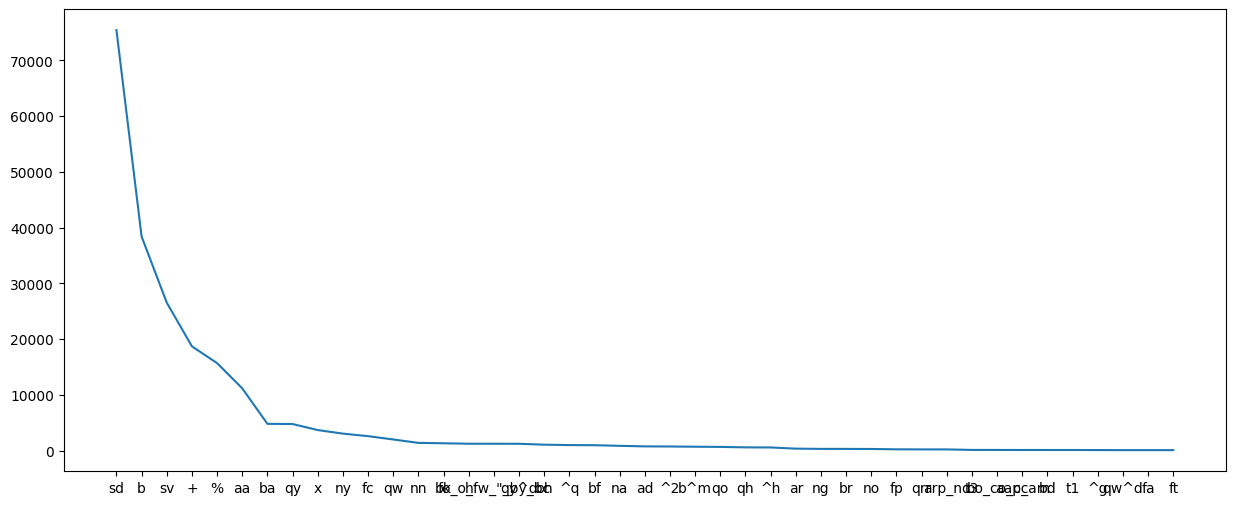

In [33]:
# Plot the frequencies of the classes
plt.figure(figsize=(15,6))
plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training.

In [34]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(tags_encoding), y=tags_encoding)
print(class_weights)
d_class_weights = dict(enumerate(class_weights))
d_class_weights = list(d_class_weights.values())


[ 8.9967812   7.91497646  2.01165939  3.77368616 55.91547887 25.12144703
  4.23809253 65.00174419  5.27397519  9.33597762 65.82455107 47.27399577
  7.12347881 15.07286822  1.08403993 44.44563705  7.54737233 49.52513843
 50.00134168 17.39177102  2.61313544  0.13548734 23.11173127 50.4867916
  1.09246629  5.41117537 18.18230607 17.16217668  4.25543333  0.33159926
 66.66845558  4.27291663  0.27821623 24.76256921  0.19603195  0.46608762
  6.91507917  1.41384979  1.71057222  3.97260469  0.06896462  6.11062225
  4.91971574]


## Define & Train the model

In [35]:
"""
Task 2 2/2

Begin
"""
# Instantiate the model
model_balanced = BiLSTMModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_length=MAX_LENGTH
)


In [36]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
train(model_balanced, train_dataset, val_dataset, 5, 1e-3, 256, device, d_class_weights)

Epoch 1, Train Loss: 3.205248034632402
Validation Loss: 2.582314808434303, Accuracy: 0.42329627490615074
Epoch 2, Train Loss: 2.5898977568206227
Validation Loss: 2.230139832977855, Accuracy: 0.3876696505919723
Epoch 3, Train Loss: 2.2997054016350393
Validation Loss: 2.06714293825517, Accuracy: 0.4099408027721629
Epoch 4, Train Loss: 2.0923143641604365
Validation Loss: 1.9595506027204181, Accuracy: 0.3950332082009818
Epoch 5, Train Loss: 1.9182303058599859
Validation Loss: 1.9101106212773453, Accuracy: 0.41748483973433437


## Test the model

In [37]:
# Overall Accuracy
eval(model_balanced, test_dataset, 100, device)


Overall Loss: 1.9439, Acc: 0.4053


In [38]:
# Generate predictions for the test data
label_pred = predict(model_balanced, test_dataset, 100, device)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [39]:
# Build the confusion matrix off these predictions
matrix_balanced = sklearn.metrics.confusion_matrix(y_test, label_pred)

# Calculate Accuracies for "br" and "bf"
br_accuracy_balanced = matrix_balanced[br_idx, br_idx] / np.sum(matrix_balanced[br_idx, :]) if np.sum(matrix_balanced[br_idx, :]) > 0 else 0
bf_accuracy_balanced = matrix_balanced[bf_idx, bf_idx] / np.sum(matrix_balanced[bf_idx, :]) if np.sum(matrix_balanced[bf_idx, :]) > 0 else 0

print(f"Accuracy for 'br' class (balanced): {br_accuracy_balanced:.4f}")
print(f"Accuracy for 'bf' class (balanced): {bf_accuracy_balanced:.4f}")

"""
End Task 2 2/2
"""

Accuracy for 'br' class (balanced): 0.5970
Accuracy for 'bf' class (balanced): 0.0690


'\nEnd Task 2 2/2\n'





### Explanation



### Other ways to handle imbalanced classes


- The model can be turned into multiple single-class classifiers, giving a confidence score for each of the classes. Instead of just taking the highest confidence class, the model can run the individual classifiers in ascending order of frequency of the classes in the training corpus.  The first classifier to classify the data point over a certain confidence threshold determines the class given to the example. This gives chance for the minority class classifiers to classify before the frequent classes arrive with their more confident predicitions.

- Transfer Learning could also be implemented, to initialise weights on a larger dataset, where these minority classes may be prevelant. This would allow fine-tuning with the small data for this particular application.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of
previous DA tags, plus the utterance representation.

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance.

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

## BiLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

Concatenate 2 last layers and create the output layer
network

In [40]:
import torch.nn.functional as F

filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags)

class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, filter_sizes, num_filters, dropout=0.2):
        super(CNN_BiLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)

        # Convolution blocks (Conv2D + BatchNorm + ReLU), one per filter size
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=1,
                          out_channels=num_filters,
                          kernel_size=(fs, embed_size),  # (filter_size, embedding_dim)
                          stride=1,
                          padding=0),
                nn.BatchNorm2d(num_filters),
                nn.ReLU()
            ) for fs in filter_sizes
        ])

        # After max pooling each convolution output, we concatenate them.
        # The shape after concatenation will be [batch_size, len(filter_sizes), 1, num_filters].
        # We'll flatten it to [batch_size, 1, len(filter_sizes)*num_filters].

        # First Dense layer (Dense_1) that maps CNN outputs down to EMBED_SIZE
        self.dense_1 = nn.Linear(num_filters * len(filter_sizes), embed_size)
        self.dropout_1 = nn.Dropout(dropout)

        # Two stacked BiLSTM layers
        # - The first BiLSTM has EMBED_SIZE hidden units, bidirectional => output_dim=2*EMBED_SIZE
        # - The second BiLSTM takes 2*EMBED_SIZE as input (from the first BiLSTM if return_sequences=True).
        #   Since it's bidirectional, final output_dim of the second BiLSTM is 2*EMBED_SIZE as well.
        self.blstm1 = nn.LSTM(input_size=embed_size, hidden_size=embed_size,
                              batch_first=True, bidirectional=True)
        self.blstm2 = nn.LSTM(input_size=2*embed_size, hidden_size=embed_size,
                              batch_first=True, bidirectional=True)

        # Second Dense layer (Dense_2) after the second BiLSTM
        # This projects 2*EMBED_SIZE down to EMBED_SIZE
        self.dense_2 = nn.Linear(2 * embed_size, embed_size)
        self.dropout_2 = nn.Dropout(dropout)

        # Final output layer (Output)
        self.output = nn.Linear(embed_size + embed_size, hidden_size)  # concatenating two EMBED_SIZE vectors

    def forward(self, x):
        """
        x shape: [batch_size, MAX_LENGTH]
        """
        # 1) Embedding
        x = self.embedding(x)               # [batch_size, MAX_LENGTH, EMBED_SIZE]
        x = x.unsqueeze(1)                  # [batch_size, 1, MAX_LENGTH, EMBED_SIZE] so we can apply Conv2D

        # 2) Parallel Convolutions -> BN -> ReLU -> MaxPool
        # Each conv_block expects input of shape [batch_size, 1, MAX_LENGTH, EMBED_SIZE].
        pooled_outputs = []
        for conv in self.conv_blocks:
            conv_out = conv(x)  # shape: [batch_size, num_filters, (MAX_LENGTH - fs + 1), 1]
            # Perform 2D max pooling across the variable spatial dimension conv_out.shape[2] and width=1
            # This collapses each feature map to a single value per filter.
            pooled = F.max_pool2d(conv_out, kernel_size=(conv_out.shape[2], conv_out.shape[3]))
            # Now shape: [batch_size, num_filters, 1, 1]
            pooled_outputs.append(pooled)

        """
        Task 3 1/2

        Begin
        """
        # Concatenate along the channel dimension (num_filters dimension)
        # After pooling, each block has shape [batch_size, num_filters, 1, 1].
        # concatenation => [batch_size, len(filter_sizes)*num_filters, 1, 1]
        x = torch.cat(pooled_outputs, 1)

        # 3) Flatten to [batch_size, 1, len(filter_sizes)*num_filters]
        x = x.view(x.size(0), 1, -1)

        # 4) Dense_1 + Dropout
        x = self.dense_1(x)
        dropout_1 = self.dropout_1(x)  # [batch_size, 1, EMBED_SIZE]

        # 5) BiLSTM_1 (return_sequences=True)
        # Input shape: [batch_size, sequence_len, EMBED_SIZE]
        # Output shape: [batch_size, sequence_len, 2*EMBED_SIZE]
        blstm1_out, _ = self.blstm1(dropout_1)

        # 6) BiLSTM_2 (no return_sequences => final hidden state)
        # Input shape: [batch_size, sequence_len, 2*EMBED_SIZE]
        # final_timestep shape: [2, batch_size, EMBED_SIZE]
        _, (final_timestep, _) = self.blstm2(blstm1_out)

        # 7) Dense_2 + Dropout
        # Concatenate the final forward and backward hidden states
        final_timestep = torch.cat((final_timestep[0], final_timestep[1]), dim=1)  # [batch_size, 2*EMBED_SIZE]
        out = self.dense_2(final_timestep)
        dropout_2 = self.dropout_2(out)  # [batch_size, EMBED_SIZE]

        # 8) Concatenate Flatten(dropout_1) and dropout_2
        # Flatten(dropout_1) => shape [batch_size, EMBED_SIZE]
        # out => [batch_size, EMBED_SIZE]
        # Note: dropout_1 was [batch_size, 1, EMBED_SIZE], so flatten the second dimension:
        dropout_1_flattened = dropout_1.squeeze(1)  # [batch_size, EMBED_SIZE]
        concatenated = torch.cat((dropout_1_flattened, dropout_2), dim=1)  # [batch_size, 2*EMBED_SIZE]

        # 9) Output layer
        logits = self.output(concatenated)
        return logits

model_context = CNN_BiLSTM(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    filter_sizes=filter_sizes,
    num_filters=num_filters,
    dropout=drop
)
print(model_context)

CNN_BiLSTM(
  (embedding): Embedding(43732, 100)
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 100), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 100), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 100), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (dense_1): Linear(in_features=192, out_features=100, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (blstm1): LSTM(100, 100, batch_first=True, bidirectional=True)
  (blstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (dense_2): Linear(in_features=200, out_features=100, bias=True)
  (dropout_2): Dr

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [41]:
"""
Task 3 2/2

Begin
"""
# Train the context model
train(model_context, train_dataset, val_dataset, 5, 1e-3, 256, device)

# Evaluate the model
eval(model_context, test_dataset, 100, device)

# Generate predictions and analyze performance on minority classes
label_pred_context = predict(model_context, test_dataset, 100, device)
matrix_context = sklearn.metrics.confusion_matrix(y_test, label_pred_context)

# Calculate accuracies for minority classes
br_accuracy_context = matrix_context[br_idx, br_idx] / np.sum(matrix_context[br_idx, :]) if np.sum(matrix_context[br_idx, :]) > 0 else 0
bf_accuracy_context = matrix_context[bf_idx, bf_idx] / np.sum(matrix_context[bf_idx, :]) if np.sum(matrix_context[bf_idx, :]) > 0 else 0

print(f"Accuracy for 'br' class (context): {br_accuracy_context:.4f}")
print(f"Accuracy for 'bf' class (context): {bf_accuracy_context:.4f}")
# Print the frequency of the "br" and "bf" classes



"""
End Task 3 2/2
"""

Epoch 1, Train Loss: 1.2152019124580258
Validation Loss: 0.9947237263032056, Accuracy: 0.6911998267398209
Epoch 2, Train Loss: 0.9979649824677699
Validation Loss: 0.9469670932227319, Accuracy: 0.7002237943979209
Epoch 3, Train Loss: 0.9190205180884715
Validation Loss: 0.9074626209539011, Accuracy: 0.7080205024545192
Epoch 4, Train Loss: 0.8621373906649881
Validation Loss: 0.9211099432149065, Accuracy: 0.706287900664164
Epoch 5, Train Loss: 0.8091948022572171
Validation Loss: 0.9361424637497018, Accuracy: 0.7046274906150737
Overall Loss: 0.9599, Acc: 0.6956
Accuracy for 'br' class (context): 0.4925
Accuracy for 'bf' class (context): 0.0129


'\nEnd Task 3 2/2\n'